# Overview

The main purpose of this notebook is to give an overview of possibilities that can be acheived with SasView CLI. SasView consists of a few major modules:

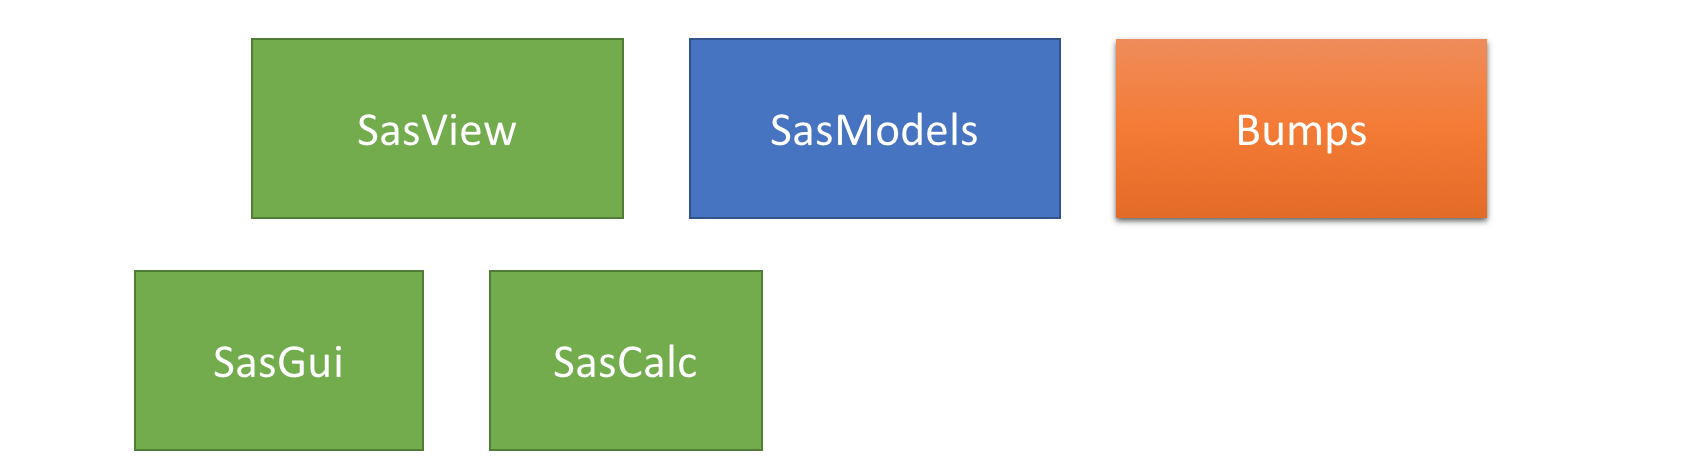

In [1]:
from IPython.display import Image
Image("SasView_structure.png")

This notebook involves using SasCalc, SasModels and Bumps

# SasCalc example

A simple example demonstarting pair distance distribution function P(r) inversion. In SasView it is calculated using Moore formula (1980)

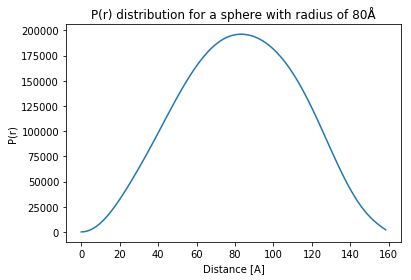

In [2]:
from sas.sascalc.dataloader.loader import Loader
from sas.sascalc.pr.invertor import Invertor
import matplotlib.pyplot as plt
import numpy as np
    
loader = Loader()
test_data = loader.load("sphere_80_err.txt")
x_data = test_data[0].x
y_data = test_data[0].y
z_data = test_data[0].dy

pr = Invertor()
pr.x = x_data
pr.y = y_data
pr.err = z_data

pr.alpha = 2.6e-5
pr.d_max = 160

#nfunc - number of base functions to use.
out, cov = pr.invert(nfunc=13)
pr_value = []
err_value = []
r = np.arange(0.0, pr.d_max, pr.d_max / pr.x.size)
for r_i in r:
    (value, err) = pr.pr_err(out, cov, r_i)
    pr_value.append(value)
    err_value.append(err)

plt.plot(r,pr_value)
plt.xlabel("Distance [A]")
plt.ylabel("P(r)")
plt.title('P(r) distribution for a sphere with radius of 80Å')
plt.show()

# SasModels example

SasModels is a library of form and strcuture factor functions. The following example demonstrates how to generate a scattering pattern of a form factor of the cylinder model using sasmodels library. It requires sasmodels to be installed in the path.

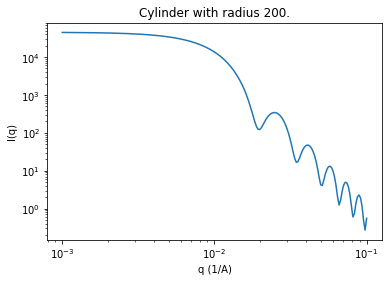

In [3]:
from numpy import logspace
from matplotlib import pyplot as plt
from sasmodels.core import load_model
from sasmodels.direct_model import call_kernel

model = load_model('cylinder')
q = logspace(-3, -1, 200)
kernel = model.make_kernel([q])
Iq = call_kernel(kernel, dict(radius=200))
plt.loglog(q, Iq)
plt.xlabel('q (1/A)')
plt.ylabel('I(q)')
plt.title('Cylinder with radius 200.')
plt.show()

# Fitting model function to data using bumps

The model functions from sasmodels can be used to fit experimental data. This can be done using bumps, which simillar to sasmodels is a separate package and needs to be installed in your path.

Initial chisq 416.09(13)


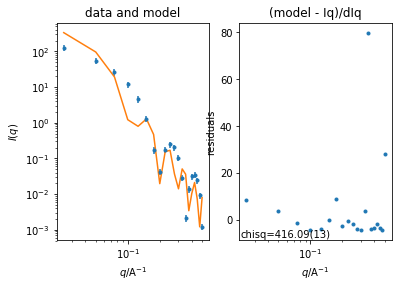

Final chisq 0.03(13)
length : 464.9(55)
radius : 19.977(64)


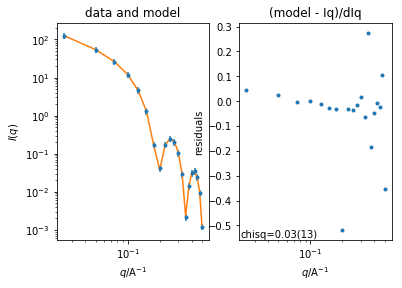

In [4]:
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

import pylab

test_data = load_data('cyl_400_20.txt')
kernel = load_model('cylinder')

#We set some errors for demonstration
test_data.dy = 0.2*test_data.y 

pars = dict(radius=35, 
            length=350,
            background=0.0,
            scale=1.0,
            sld=4.0,
            sld_solvent=1.0)
model = Model(kernel, **pars)

# SET THE FITTING PARAMETERS
model.radius.range(1, 50)
model.length.range(1, 500)

M = Experiment(data=test_data, model=model)
problem = FitProblem(M)
print("Initial chisq", problem.chisq_str())
problem.plot()
pylab.show()

result = fit(problem, method='amoeba')
print("Final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))
problem.plot()
pylab.show()

# Fitting to 2 dimensional data

Sasmodels can also handle 2D data. This example ilustarted fitting 2D ellipsoid model to the data. bumps is called from external command, which may have some performanace benefits.

background 73.0282890454579
radius_equatorial 390.222830262081
radius_polar 16.6486493951376
scale 7.22854462350096e-07
theta_pd 124.282455186553


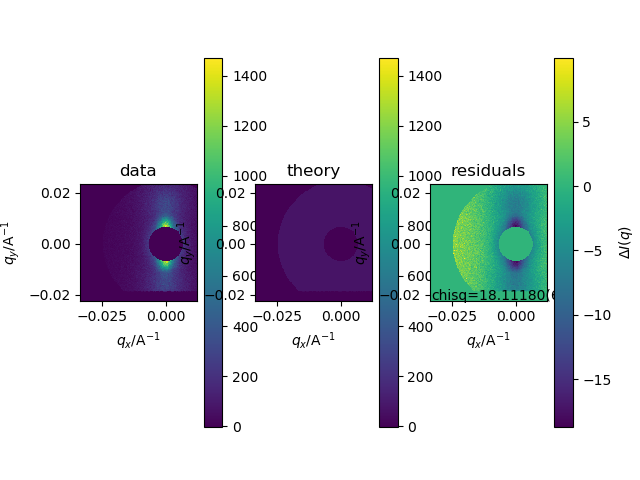

In [5]:
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, set_beam_stop, set_top

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

import sys
import os

radial_data = load_data('DEC07267.DAT')
set_beam_stop(radial_data, 0.00669, outer=0.025)
set_top(radial_data, -.0185)

kernel = load_model("ellipsoid")

model = Model(kernel,
    scale=0.08,
    radius_polar=15, radius_equatorial=800,
    sld=.291, sld_solvent=7.105,
    background=0,
    theta=90, phi=0,
    theta_pd=15, theta_pd_n=40, theta_pd_nsigma=3,
    radius_polar_pd=0.222296, radius_polar_pd_n=1, radius_polar_pd_nsigma=0,
    radius_equatorial_pd=.000128, radius_equatorial_pd_n=1, radius_equatorial_pd_nsigma=0,
    phi_pd=0, phi_pd_n=20, phi_pd_nsigma=3,
    )

# SET THE FITTING PARAMETERS
model.radius_polar.range(15, 1000)
model.radius_equatorial.range(15, 1000)
model.theta_pd.range(0, 360)
model.background.range(0,1000)
model.scale.range(0, 10)

#cutoff = 0     # no cutoff on polydisperisity loops
#cutoff = 1e-5  # default cutoff
cutoff = 1e-3  # low precision cutoff
M = Experiment(data=radial_data, model=model, cutoff=cutoff)
problem = FitProblem(M)

#Run bumps from command line
model_file = "ellipsoid_bumps.py"
bumps_cmd = "python -m bumps.cli --fit=amoeba --steps=1000 --store=T1"
cmd = " ".join((bumps_cmd, model_file))
os.system(cmd)

# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'

with open(os.path.join("T1", par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print (parameter, value) 
# PLOT OF "THEORETICAL" AND FITTED DATA (Bumps output)
path_to_file_to_plot=os.path.join("T1", "ellipsoid_bumps-model.png")
from IPython.display import Image
Image(filename = path_to_file_to_plot)     

# Batch fitting example

This is the example ilustarting how fitting to multiple data sets can be acheived. 
This example has been developed during code CodeCampV in Grenoble, Apr 2017 by Miguel Gonzales and Marco Adamo.

The script reads a series of files from GRASP and fits the model defined by model.py.

For example ellipsoid.py fits a ellipsoid form factor model. 

For each file a directory named Fit_filename is created. The file
model.par contains the fitted parameters, which are gathered together into
batch_fit.csv in the current directory.

Finally the fitted parameters are plotted for the full series.

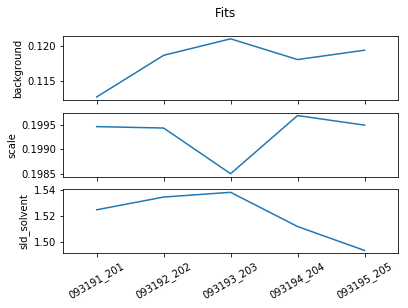

In [10]:
import sys
import os
import numpy as np

import matplotlib.pyplot as plt
from bumps.dream.views import tile_axes  # make a grid of plots

# GET INPUT AND ENSURE MODEL AND DATA FILES ARE DEFINED
model_file = "custom_ellipsoid.py"
data_files = ["093191_201.dat", "093192_202.dat","093193_203.dat", "093194_204.dat", "093195_205.dat"]
fit_opts = "--fit=lm --steps=200 --ftol=1.5e-8 --xtol=1.5e-8"
fit_opts = [v for v in fit_opts if v.startswith('--')]

# CHECK THAT DATA FILES EXIST
missing = [filename for filename in data_files if not os.path.isfile(filename)]
if missing:
    print("Missing data files: %s" % ", ".join(missing))
    sys.exit(1)

# STORE DIRECTORY FOR BUMPS FITS
def fit_dir(filename):
    "Return the store directory name for the given file"
    return "Fit_" + os.path.splitext(filename)[0]

# LOOP OVER FILES AND CALL TO BUMPS FOR EACH OF THEM
bumps_cmd = "python -m bumps.cli --batch"
fit_opts = " ".join(fit_opts)
for data_file in data_files:
    store_opts = "--store=" + fit_dir(data_file)
    cmd = " ".join((bumps_cmd, fit_opts, store_opts, model_file, data_file))
    os.system(cmd)

# GATHER RESULTS
results = {}
par_file = os.path.splitext(model_file)[0] + '.par'
for data_file in data_files:
    with open(os.path.join(fit_dir(data_file), par_file), 'r') as fid:
        for line in fid:
            parameter, value = line.split()
            results.setdefault(parameter, []).append(float(value))

# SAVE RESULTS INTO FILE
with open('batch_fit.csv', 'w') as fid:
    parameters = list(sorted(results.keys()))
    values_by_file = zip(*(v for k, v in sorted(results.items())))
    fid.write(','.join(['filename'] + parameters) + '\n')
    for filename, values in zip(data_files, values_by_file):
        fid.write(','.join([filename] + [str(v) for v in values]) + '\n')

# SHOW FITTED PARAMETERS
nh, nw = tile_axes(len(results))
ticks = np.arange(1, len(data_files)+1)
labels = [os.path.splitext(filename)[0] for filename in data_files]
for k, (parameter, values) in enumerate(sorted(results.items())):
    plt.subplot(nh, nw, k+1)
    plt.plot(ticks, values)
    plt.xlim(ticks[0]-0.5, ticks[-1]+0.5)
    if k%nh == nh-1:
        plt.xticks(ticks, labels, rotation=30)
    else:
        plt.xticks(ticks, [' ']*len(labels))
    plt.ylabel(parameter)
plt.suptitle("Fits")
plt.show()

Customized elipsoid model used by the previous script

In [ ]:
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data

from bumps.names import *

import sys
import numpy as np

# IMPORT THE DATA USED
data = load_data(sys.argv[1])

# DEFINE THE MODEL
kernel = load_model('ellipsoid')

pars = dict(scale=0.08, background=35,
        radius_polar=15, radius_equatorial=800,
        sld=.291, sld_solvent=7.105,
        theta=89.9, phi=90,
        theta_pd=0, theta_pd_n=0, theta_pd_nsigma=3,
        phi_pd=0, phi_pd_n=20, phi_pd_nsigma=3,
        radius_polar_pd=0.222296, radius_polar_pd_n=1, radius_polar_pd_nsigma=0,
        radius_equatorial_pd=.000128, radius_equatorial_pd_n=1, radius_equatorial_pd_nsigma=0)

model = Model(kernel, **pars)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
model.scale.range(0, inf)
model.background.range(-inf, inf)
model.sld_solvent.range(-inf, inf)

M = Experiment(data=data, model=model)

problem = FitProblem(M)


## Final remarks

* Runing bumps via script vs bumps via fit() depends on the workflow and the resources one has. If you can run you problem on a batch queuing system and run a bunch of fits in parallel on cluster, then command line will be better.  For interactive use, it seems like calling fit() is a bit nicer.

* sasmodels and bumps are available from pypi and can be installed using following commands:

In [ ]:
pip install sasmodels 
pip install bumps

This can also be done from jupyter notebook with command:

In [ ]:
import sys
!{sys.executable} -m pip install bumps

sascalc is distributed as a part of sasview and it is currently not avaialable from pypi. It can be easily installed by following: http://trac.sasview.org/wiki/CondaDevSetup5.0

* You may need to call sas.sasview.setup_sasmodels() in your notebook to set the path to the plugin models and to retrieve the opencl setting.